In [1]:
%load_ext autoreload
%autoreload 2

# Simple Likelihood

In [2]:
#|default_exp simple_likelihood

In [3]:
#|export
import jax
import jax.numpy as jnp
from   jax import jit, vmap
import genjax
from   genjax import gen, choice_map, vector_choice_map
import matplotlib.pyplot as plt
import numpy as np
import bayes3d
from bayes3d._mkl.utils import *

key = jax.random.PRNGKey(0)

In [4]:
#|export
import genjax._src.generative_functions.distributions.tensorflow_probability as gentfp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

uniform = genjax.tfp_uniform

truncnormal = gentfp.TFPDistribution(
    lambda mu, sig, low, high: tfd.TruncatedNormal(mu, sig, low, high));

normal = gentfp.TFPDistribution(
    lambda mu, sig: tfd.Normal(mu, sig));

diagnormal = gentfp.TFPDistribution(
    lambda mus, sigs: tfd.MultivariateNormalDiag(mus, sigs));


mixture_of_diagnormals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.MultivariateNormalDiag(mus, sig * jnp.ones_like(mus))))

mixture_of_normals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.Normal(mus, sig * jnp.ones_like(mus))))


mixture_of_truncnormals = gentfp.TFPDistribution(
    lambda ws, mus, sigs, lows, highs: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.TruncatedNormal(mus, sigs, lows, highs)))

In [5]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf


## Pixelwise Gaussian and uniform outlier

In [31]:
# def cam_to_screen(x): return jnp.array([x[0]/x[2], x[1]/x[2], jnp.linalg.norm(x)])
# def screen_to_cam(y): return y[2]*jnp.array([y[0], y[1], 1.0])

In [6]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_simple_sensor_model(zmax):
    """Returns an simple sensor model marginalized over outliers."""    

    @genjax.drop_arguments
    @genjax.gen
    def _sensor_model(y, sig, outlier):
        
    
        # Compute max range along ray ending at far plane
        # and adding some wiggle room
        z_ = jnp.linalg.norm(y)
        zmax_ = z_/y[2]*zmax

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [truncnormal, genjax.tfp_uniform])
        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (z_, sig, 0.0, zmax_), 
                                    (0.0, zmax_ + 1e-6))) @ "measurement"

        z = jnp.clip(z, 0.0, zmax_)

        return z * y/z_

        
    @genjax.gen
    def sensor_model(Y, sig, out):   
        """
        Simplest sensor model that returns a vector of range measurements conditioned on 
        an image, noise level, and outlier probability.
        """
                
        X = genjax.Map(_sensor_model, (0,None,None))(Y[...,:3].reshape(-1,3), sig, out) @ "X"
        X = X.reshape(Y.shape)

        return X

    return sensor_model

In [7]:
model = make_simple_sensor_model(5.0)

Y= jnp.array([
    [
            [0,0,1],
            [0,1,2],
    ],
    [
            [1,1,3],
            [1,0,4]
    ]
])
Y.shape
Y[...,2]

Array([[1, 2],
       [3, 4]], dtype=int32)

In [8]:
key = keysplit(key)
model(Y,0.1,0.1)(key)

Array([[[0.        , 0.        , 0.9474796 ],
        [0.        , 0.95539385, 1.9107877 ]],

       [[1.0142542 , 1.0142542 , 3.0427625 ],
        [0.99212784, 0.        , 3.9685113 ]]], dtype=float32)

## Pixelwise Step Function 

In [27]:
#|export
def make_simple_step_sensor_model(far):
    """Returns an simple step function sensor model marginalized over outliers."""    

    @genjax.drop_arguments
    @genjax.gen
    def _sensor_model_pixel(y, sig, out):
        

        # Compute max range along ray ending at far plane
        r_   = jnp.linalg.norm(y)
        rmax = r_/y[2]*far 

        inlier_outlier_mix = genjax.tfp_mixture(
                                genjax.tfp_categorical, 
                                [genjax.tfp_uniform, genjax.tfp_uniform])

        # The `1e-4` term helps with numerical issues from computing rmax
        # at least that's what I think
        r = inlier_outlier_mix(
                [jnp.log(1 - out), jnp.log(out)], 
                ((jnp.maximum(r_-sig, 0.0) , jnp.minimum(r_+sig, rmax)), (0.0, rmax + 1e-4))) @ "measurement"

        r = jnp.clip(r, 0.0, rmax)

        return r * y/r_

        
    @genjax.gen
    def sensor_model(Y, sig, out):
        """
        Simplest sensor model that returns a vector of range measurements conditioned on 
        an image, noise level, and outlier probability.
        """
            
        X = genjax.Map(_sensor_model_pixel, (0,None,None))(Y[...,:3].reshape(-1,3), sig, out) @ "X"
        X = X.reshape(Y[...,:3].shape)

        return X

    return sensor_model

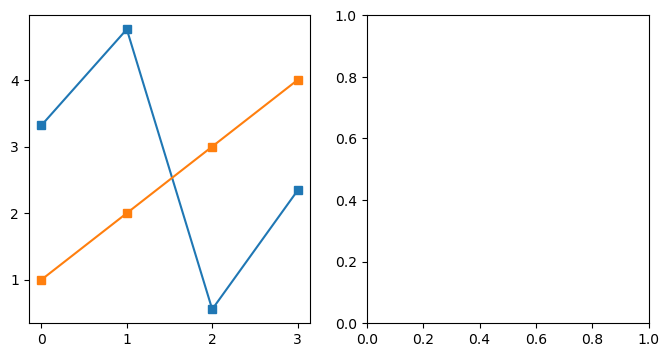

In [28]:
zmax = 5.0
model = make_simple_step_sensor_model(zmax)


Y= jnp.array([
    [
            [0,0,1],
            [0,1,2],
    ],
    [
            [1,1,3],
            [1,0,4]
    ]
])

key = keysplit(key)
X = model(Y, 0.1 , 0.2)(key)


fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(X[...,2].ravel(), marker="s")
axs[0].plot(Y[...,2].ravel(), marker="s")

## Score Wrapper

In [30]:
#|export
from genjax._src.generative_functions.distributions.distribution import ExactDensity

def wrap_into_dist(score_func):
    """
    Takes a scoring function 

        `score_func(observed, latent, ...)` 

    and wraps it into a genjax distribution.
    """
    class WrappedScoreFunc(ExactDensity):
        def sample(self, key, latent, *args): return latent
        def logpdf(self, observed, latent, *args): return score_func(observed, latent, *args)

    return WrappedScoreFunc()
